In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('../data/sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                #(df_sales['date']>pd.to_datetime('2014-10-01'))&
                                (df_sales['item_id']==20949)]
                                
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet['log_item_cnt_day_total'] = np.log(df_sales_fbprophet['item_cnt_day_total'])
df_sales_fbprophet=df_sales_fbprophet[['date','log_item_cnt_day_total']]
df_sales_fbprophet


,date,log_item_cnt_day_total
0,2013-04-24,2.079442
1,2013-04-25,3.218876
2,2013-04-26,3.761200
3,2013-04-27,3.637586
4,2013-04-28,3.637586
...,...,...
916,2015-10-27,4.304065
917,2015-10-28,4.499810
918,2015-10-29,4.521789
919,2015-10-30,4.770685


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "log_item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=-2
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2013-04-24,2.079442,-2,7.036148
1,2013-04-25,3.218876,-2,7.036148
2,2013-04-26,3.761200,-2,7.036148
3,2013-04-27,3.637586,-2,7.036148
4,2013-04-28,3.637586,-2,7.036148
...,...,...,...,...
916,2015-10-27,4.304065,-2,7.036148
917,2015-10-28,4.499810,-2,7.036148
918,2015-10-29,4.521789,-2,7.036148
919,2015-10-30,4.770685,-2,7.036148


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
            #growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [6]:
# find how many periods we need by finding the last day in the item
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
days_to_predict.days

92

In [7]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=-2
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
1008,2016-01-27,-2,7.036148
1009,2016-01-28,-2,7.036148
1010,2016-01-29,-2,7.036148
1011,2016-01-30,-2,7.036148
1012,2016-01-31,-2,7.036148


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1008,2016-01-27,4.067111,3.637429,4.545965
1009,2016-01-28,4.095939,3.613553,4.557815
1010,2016-01-29,4.229879,3.794827,4.660870
1011,2016-01-30,4.395676,3.932489,4.863772
1012,2016-01-31,4.270869,3.843776,4.684064


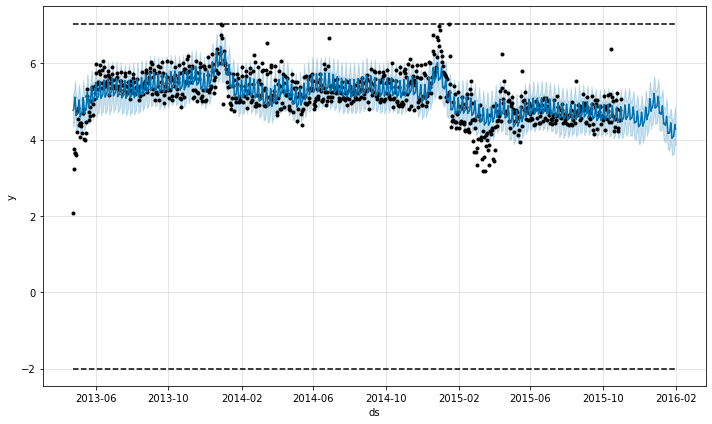

In [9]:
fig1 = m.plot(forecast)

In [10]:
# 30 days of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'])

921    113.725893
922     87.710405
923     93.427466
924     93.528511
925     97.474125
926    113.091436
927    135.366421
928    119.567070
929     92.202715
930     97.925855
931     97.588001
932    101.054115
933    116.263103
934    137.775534
935    120.436393
936     91.852794
937     96.311493
938     94.730712
939     96.795677
940    109.878414
941    128.538934
942    111.133963
943     83.979547
944     87.307485
945     85.331065
946     86.825457
947     98.359813
948    115.125256
949     99.960940
950     76.105725
Name: yhat, dtype: float64

In [11]:
# forecast for the whole month of November
np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']).sum()

3079.3743182354474